# A Comprehensive Introduction of Medusa
Sept, 2023 | 45 min | Yuhong Li

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0" # define GPU id, remove if you want to use all GPUs available
import torch
from contextlib import contextmanager
import numpy as np
from medusa.model.modeling_llama_ssd_router import LlamaForCausalLM, add_router
# from transformers.models.llama.modeling_llama import LlamaForCausalLM 
from medusa.model.configuration_llama_ssd import LlamaConfig
from medusa.model.kv_cache import *
from medusa.model.utils import *

from copy import deepcopy
import matplotlib.pyplot as plt

from transformers import top_k_top_p_filtering
import json

from peft import PeftModel, PeftConfig

(Re-)Loading modeling...


In [2]:
model_name = '/root/MODELS/vicuna-7b-v1.3'

top_layers_len = 24
top_k_group = 4
resnet_num = 1

config_kwargs = {}

config_kwargs["top_layers_len"] = top_layers_len 
config_kwargs["top_k_group"] = top_k_group 
config_kwargs["resnet_num"] = resnet_num 

config = LlamaConfig.from_pretrained(model_name, **config_kwargs)
# config.num_skipped_draft_model = len(draft_attn_skip_masks) 

# print(config.num_skipped_draft_model)

lora_path = "/root/idea/speculative_decoding/Medusa/axolotl/vicuna-7b-v1.3-qlora-ssd-out-router-top-24-k-4-seq-1024"
lora_config = PeftConfig.from_pretrained(lora_path)

model = LlamaForCausalLM.from_pretrained(
    model_name,
    torch_dtype=torch.float16,
    config=config,
)
model = model.eval().cuda()

add_router(model)

model = PeftModel.from_pretrained(model, lora_path)



Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

/root/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


### Initialize the kv_cache

In [3]:
past_key_values, past_key_values_data, current_length_data = initialize_past_key_values(model)
model.past_key_values = past_key_values
model.past_key_values_data = past_key_values_data
model.current_length_data = current_length_data

# draft_attn_skip_masks = [[4, 7, 10, 17, 20, 24, 29, 30]] * 4
# draft_mlp_skip_masks = [[2, 6, 7, 10, 15, 23, 25, 29]] * 4

### Set the prompt

The prompt is as follow:

A chat between a curious user and an artificial intelligence assistant. The assistant gives helpful, detailed, and polite answers to the user's questions. USER: Hi, could you share a tale about a charming llama that grows Medusa-like hair and starts its own coffee shop? ASSISTANT:

In [4]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name)
model.current_length_data.zero_() # this is for rerun
prompt = "A chat between a curious user and an artificial intelligence assistant. The assistant gives helpful, detailed, and polite answers to the user's questions. USER: Hi, could you share a tale about a charming llama that grows Medusa-like hair and starts its own coffee shop? ASSISTANT:"
print(prompt)
input_ids = tokenizer([prompt]).input_ids
input_len = len(input_ids[0])
input_ids = torch.as_tensor(input_ids).cuda()
print('Input token length:', len(input_ids[0]))
print('Init KV cache shape for attention modules:', model.past_key_values[0][0].shape, model.past_key_values[0][1].shape)

def sample(logits, return_probs: bool=False, do_sample: bool=False, top_k: int=50, top_p: float=0.8, temperature: float=0.7):

    if return_probs:

        all_probs = logits.softmax(-1)
        if do_sample and top_k != 1 and top_p != 0.0 and temperature != 0.0:
            _logits = top_k_top_p_filtering(logits.view(-1, logits.size(-1)) / temperature, top_k=top_k, top_p=top_p)
            output_ids = torch.multinomial(_logits.softmax(-1), num_samples=1).view(logits.shape[:-1])
            probs = torch.gather(all_probs, -1, output_ids.unsqueeze(-1)).squeeze(-1)
        else:
            probs, output_ids = torch.max(all_probs, dim=-1)
            
        return output_ids, probs

    else:

        if do_sample and top_k != 1 and top_p != 0.0 and temperature != 0.0:
            _logits = top_k_top_p_filtering(logits.view(-1, logits.size(-1)) / temperature, top_k=top_k, top_p=top_p)
            output_ids = torch.multinomial(_logits.softmax(-1), num_samples=1).view(logits.shape[:-1])
        else:
            output_ids = torch.argmax(logits, dim=-1)
            
        return output_ids
    
def get_nucleus_one_token(logit, temperature, top_p):
    """
    Performs token sampling based on the nucleus (top-p) sampling method.

    This function selects a token from a given logit distribution using the nucleus sampling strategy.
    It allows for more controlled and diverse generation compared to traditional top-k sampling.

    Args:
        logit (torch.Tensor): The logits from a language model output, expected to be a 2D tensor (BxC).
        temperature (float): A temperature parameter to control the randomness in sampling.
                             Higher values increase diversity, lower values make selections more deterministic.
        top_p (float): The cumulative probability threshold for nucleus sampling.
                       It controls the size of the set of high-probability tokens to consider for sampling.

    Returns:
        torch.Tensor: A tensor containing the indices of the sampled tokens.
    """
    if top_p >= 1:
        return torch.multinomial(F.softmax(logit / temperature, dim=-1), 1)
    logit = logit / temperature
    probs = torch.softmax(logit, dim=-1)
    sorted_logits, sorted_indices = torch.sort(probs, descending=True)
    cum_probs = torch.cumsum(sorted_logits, dim=-1)
    sorted_indices_to_remove = cum_probs > top_p
    sorted_indices_to_remove[..., 1:] = sorted_indices_to_remove[..., :-1].clone()
    sorted_indices_to_remove[..., 0] = 0
    indices_to_remove = sorted_indices_to_remove.scatter(dim=1, index=sorted_indices, src=sorted_indices_to_remove)
    logit[indices_to_remove] = float('-inf')
    sampled_tokens = torch.multinomial(F.softmax(logit, dim=-1), 1)
    return sampled_tokens

def get_typical_one_token(logit, temperature, posterior_threshold, posterior_alpha):
    """
    Implements token sampling based on the typical sampling method.

    This function selects a token from a given logit distribution using the typical sampling strategy,
    aiming to balance between diversity and likelihood in a more nuanced way compared to traditional methods.

    Args:
        logit (torch.Tensor): The logits from a language model output, expected to be a 2D tensor.
        temperature (float): A parameter to control the randomness in sampling.
                              Higher values increase diversity, lower values make selections more deterministic.
        posterior_threshold (float): A threshold to decide the lower bound of probabilities to be considered for sampling.
        posterior_alpha (float): A scaling factor applied to the entropy-based adaptive threshold.

    Returns:
        torch.Tensor: A tensor containing the indices of the sampled tokens.
    """
    logit = logit / temperature
    probs = torch.softmax(logit, dim=-1)
    entropy = -torch.sum(
            probs * torch.log(probs + 1e-5), dim=-1
        )
    threshold = torch.minimum(
            torch.ones_like(entropy) * posterior_threshold,
            torch.exp(-entropy) * posterior_alpha,
        )
    indices_to_remove = probs < threshold.unsqueeze(-1)
    logit[indices_to_remove] = float('-inf')
    sampled_tokens = torch.multinomial(F.softmax(logit, dim=-1), 1)
    return sampled_tokens

def get_nucleus_posterior_mask(logits, candidates, temperature, top_p):
    """
    Generates a posterior mask for token candidates using nucleus (top-p) sampling.

    This function applies nucleus sampling to a set of logits, and then generates a mask indicating 
    which candidate tokens are selected. It adapts the sampling strategy to accommodate for 
    temperature scaling and cumulative probability thresholding.

    Args:
        logits (torch.Tensor): A tensor of logits from a language model output.
        candidates (torch.Tensor): A tensor of candidate tokens to compare against sampled tokens.
        temperature (float): A parameter to scale the logits, controlling randomness in sampling.
        top_p (float): The cumulative probability threshold for nucleus sampling.

    Returns:
        torch.Tensor: A posterior mask indicating which candidate tokens match the sampled tokens.
    """
    # adapted from https://github.com/huggingface/transformers/blob/18a879f47576822aa1a5c49aecb27d89bfa5fa69/examples/run_generation.py#L79

    # Apply temperature
    logits = logits[:, :-1] / temperature
    n_samples, n_tokens = logits.shape[0], logits.shape[1]
    logits = logits.view(n_samples*n_tokens, -1)
    if top_p >= 1:
        sampled_tokens = torch.multinomial(F.softmax(logits, dim=-1), 1)
        sampled_tokens = sampled_tokens.view(n_samples, n_tokens)
        candidates = candidates.view(-1, candidates.shape[0])
        posterior_mask = (candidates[:, 1:] == sampled_tokens).int()
        return posterior_mask
    # Convert to probabilities (softmax)
    probs = F.softmax(logits, dim=-1)
    # Sort the probabilities
    sorted_logits, sorted_indices = torch.sort(probs, descending=True)

    # Compute cumulative probabilities
    cum_probs = torch.cumsum(sorted_logits, dim=-1)

    # Create mask for the top-p nucleus
    sorted_indices_to_remove = cum_probs > top_p
    sorted_indices_to_remove[..., 1:] = sorted_indices_to_remove[..., :-1].clone()
    sorted_indices_to_remove[..., 0] = 0

    indices_to_remove = sorted_indices_to_remove.scatter(dim=1, index=sorted_indices, src=sorted_indices_to_remove)

    
    # Remove low-probability tokens
    logits[indices_to_remove] = float('-inf')
    # Sample from the remaining tokens
    sampled_tokens = torch.multinomial(F.softmax(logits, dim=-1), 1)
    sampled_tokens = sampled_tokens.view(n_samples, n_tokens)
    # Create a mask for selected tokens
    candidates = candidates.view(-1, candidates.shape[0])
    posterior_mask = (candidates[:, 1:] == sampled_tokens).int()

    return posterior_mask

def get_typical_posterior_mask(logits, candidates, temperature, posterior_threshold, posterior_alpha):
    """
    Args:
        logits (torch.Tensor): A tensor of logits from a language model output.
        candidates (torch.Tensor): A tensor of candidate tokens to compare against sampled tokens.
        temperature (float): A parameter to scale the logits, controlling randomness in sampling.
        posterior_threshold (float): The minimum threshold for probabilities to be considered in sampling.
        posterior_alpha (float): A scaling factor applied to the entropy-based adaptive threshold.

    Returns:
        torch.Tensor: A posterior mask indicating which candidate tokens match the sampled tokens.
    """
    logits = logits[:, :-1] / temperature
    n_samples, n_tokens = logits.shape[0], logits.shape[1]
    logits = logits.view(n_samples*n_tokens, -1)
    probs = F.softmax(logits, dim=-1)
    entropy = -torch.sum(
            probs * torch.log(probs + 1e-5), dim=-1
        )
    threshold = torch.minimum(
            torch.ones_like(entropy) * posterior_threshold,
            torch.exp(-entropy) * posterior_alpha,
        )
    indices_to_remove = probs < threshold.unsqueeze(-1)
    logits[indices_to_remove] = float('-inf')
    sampled_tokens = torch.multinomial(F.softmax(logits, dim=-1), 1)
    sampled_tokens = sampled_tokens.view(n_samples, n_tokens)
    candidates = candidates.view(-1, candidates.shape[0])
    posterior_mask = (candidates[:, 1:] == sampled_tokens).int()
    return posterior_mask

def evaluate_posterior(
    logits, candidates, temperature, posterior_threshold=0.3, posterior_alpha = 0.09, top_p=0.8, sampling = 'typical', fast = True
):
    """
    Evaluate the posterior probabilities of the candidates based on the provided logits and choose the best candidate.

    Depending on the temperature value, the function either uses greedy decoding or evaluates posterior
    probabilities to select the best candidate.

    Args:
    - logits (torch.Tensor): Predicted logits of shape (batch_size, sequence_length, vocab_size).
    - candidates (torch.Tensor): Candidate token sequences.
    - temperature (float): Softmax temperature for probability scaling. A value of 0 indicates greedy decoding.
    - posterior_threshold (float): Threshold for posterior probability.
    - posterior_alpha (float): Scaling factor for the threshold.
    - top_p (float, optional): Cumulative probability threshold for nucleus sampling. Defaults to 0.8.
    - sampling (str, optional): Defines the sampling strategy ('typical' or 'nucleus'). Defaults to 'typical'.
    - fast (bool, optional): If True, enables faster, deterministic decoding for typical sampling. Defaults to False.
    Returns:
    - best_candidate (torch.Tensor): Index of the chosen best candidate.
    - accept_length (int): Length of the accepted candidate sequence.
    """
    # Greedy decoding based on temperature value
    if temperature == 0:
        # Find the tokens that match the maximum logits for each position in the sequence
        posterior_mask = (
            candidates[:, 1:] == torch.argmax(logits[:, :-1], dim=-1)
        ).int()
        candidates_accept_length = (torch.cumprod(posterior_mask, dim=1)).sum(dim=1)
        accept_length = candidates_accept_length.max()
        # Choose the best candidate
        if accept_length == 0:
            # Default to the first candidate if none are accepted
            best_candidate = torch.tensor(0, dtype=torch.long, device=candidates.device)
        else:
            best_candidate = torch.argmax(candidates_accept_length).to(torch.long)
        return best_candidate, accept_length
        
    if sampling == 'typical':
        # Calculate posterior probabilities and thresholds for candidate selection
        posterior_mask = get_typical_posterior_mask(logits, candidates, temperature, posterior_threshold, posterior_alpha)
        candidates_accept_length = (torch.cumprod(posterior_mask, dim=1)).sum(dim=1)
        # Choose the best candidate based on the evaluated posterior probabilities
        accept_length = candidates_accept_length.max()
        
        if accept_length == 0:
            # If no candidates are accepted, just choose the first one
            best_candidate = torch.tensor(0, dtype=torch.long, device=candidates.device)
        else:
            best_candidate = torch.argmax(candidates_accept_length).to(torch.long)
            # Accept the best one according to likelihood
        return best_candidate, accept_length
    
    if sampling == 'nucleus':
        assert top_p < 1.0 + 1e-6, "top_p should between 0 and 1"
        posterior_mask = get_nucleus_posterior_mask(logits, candidates, temperature, top_p)
        candidates_accept_length = (torch.cumprod(posterior_mask, dim=1)).sum(dim=1)
        accept_length = candidates_accept_length.max()
        # Choose the best candidate
        if accept_length == 0:
            # Default to the first candidate if none are accepted
            best_candidate = torch.tensor(0, dtype=torch.long, device=candidates.device)
        else:
            best_candidate = torch.argmax(candidates_accept_length).to(torch.long)
        return best_candidate, accept_length
    else:
        raise NotImplementedError
    

def clip_input(tokenizer, prompt, task_name, max_new_tokens=512, prompt_shots='', max_seq_length=2048):
    print(prompt)
    if task_name == 'xsum':
        input_ids = tokenizer(
            prompt_shots +'Article: ' + prompt['document'] + '\nSummary:',
            return_tensors='pt').input_ids
    elif task_name == 'cnndm':
        input_ids = tokenizer(
            prompt_shots +'Article: ' + prompt['article'] + '\nSummary:',
            return_tensors='pt').input_ids
    elif task_name == 'humaneval':
        format_tabs=True
        if format_tabs:
            prompt = prompt['prompt'].replace("    ", "\t")
        else:
            prompt = prompt['prompt']
        input_ids = tokenizer(prompt,return_tensors='pt').input_ids
    if len(input_ids[0])+max_new_tokens>=max_seq_length:
        print(f'(input ids+max token)>max_seq_length {max_seq_length}')
        sample_num = (len(input_ids[0])+max_new_tokens-max_seq_length) 
        input_ids = torch.cat((input_ids[0][:2],input_ids[0][2:-3][:-sample_num],input_ids[0][-3:]),dim=0).unsqueeze(0)
    return  input_ids


You are using the default legacy behaviour of the <class 'transformers.models.llama.tokenization_llama.LlamaTokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thouroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


A chat between a curious user and an artificial intelligence assistant. The assistant gives helpful, detailed, and polite answers to the user's questions. USER: Hi, could you share a tale about a charming llama that grows Medusa-like hair and starts its own coffee shop? ASSISTANT:
Input token length: 66
Init KV cache shape for attention modules: (1, 32, 0, 128) (1, 32, 0, 128)


### Let's put it all together!

We now have a better understanding of the Medusa heads' inference process. Let's put the entire process together and see the compression ratio we can get for generating the whole conversation.

Prediction @ 1: ['Once']
Prediction @ 2: ['upon', 'a', 'time']
Prediction @ 3: [',']
Prediction @ 4: ['in', 'a', 'small']
Prediction @ 5: ['village', 'nest']
Prediction @ 6: ['led']
Prediction @ 7: ['in', 'the', 'And']
Prediction @ 8: ['es']
Prediction @ 9: ['mountains', ',', 'there']
Prediction @ 10: ['lived', 'a']
Prediction @ 11: ['char']
Prediction @ 12: ['ming']
Prediction @ 13: ['ll']
Prediction @ 14: ['ama']
Prediction @ 15: ['named']
Prediction @ 16: ['L']
Prediction @ 17: ['una']
Prediction @ 18: ['.']
Prediction @ 19: ['L']
Prediction @ 20: ['una']
Prediction @ 21: ['was', 'known']
Prediction @ 22: ['for']
Prediction @ 23: ['her']
Prediction @ 24: ['kind']
Prediction @ 25: ['heart']
Prediction @ 26: ['and']
Prediction @ 27: ['her']
Prediction @ 28: ['love', 'of']
Prediction @ 29: ['coffee', '.']
Prediction @ 30: ['She', 'would']
Prediction @ 31: ['often']
Prediction @ 32: ['spend']
Prediction @ 33: ['her', 'af']
Prediction @ 34: ['tern']
Prediction @ 35: ['o']
Prediction @ 36

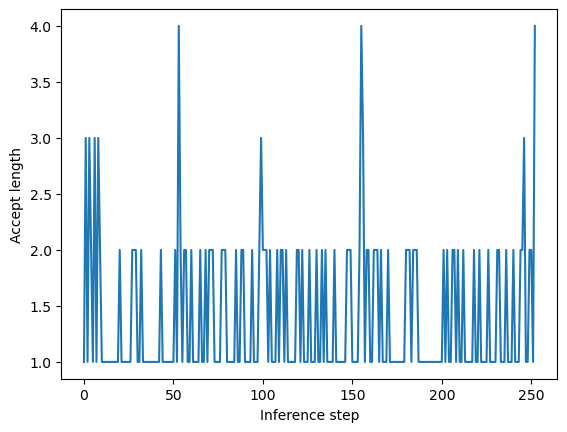

In [5]:
max_seq_length = 2048
max_new_tokens = 256
temperature = 0.7
posterior_threshold = 0.09
posterior_alpha = 0.3

inference_count = 0
accept_lengths = []

# print(input_ids)

with torch.inference_mode():

    with model.self_draft():
        # print(draft_attn_skip_masks)
        draft_logits, base_logits = model(input_ids, output_orig = True, past_key_values=model.past_key_values, top_layers_len=top_layers_len)
    inference_count += 1

    # print(draft_logits.shape) # (num_draft_layers, batch_size, seq_len, vocab_size)

    ############### Use Sampling ################
    do_sample = False
    if do_sample:
        # draft_pred = sample(draft_logits[..., -1, :], do_sample=do_sample, top_k=50, top_p=0.8, temperature=0.7)
        # draft_pred = get_nucleus_one_token(draft_logits[..., -1, :].view(-1, draft_logits.shape[-1]), temperature=0.7, top_p=0.8)
        draft_pred = get_typical_one_token(draft_logits[..., -1, :].view(-1, draft_logits.shape[-1]), temperature=temperature, posterior_threshold=posterior_threshold, posterior_alpha=posterior_alpha).view(draft_logits.shape[0], -1)
    else:
        draft_pred = torch.argmax(draft_logits[..., -1, :], dim = -1)
    #############################################  

    ############### Use Sampling ################
    do_sample = False
    if do_sample:
        # pred = sample(base_logits[..., -1, :], do_sample=do_sample, top_k=50, top_p=0.8, temperature=0.7)
        # pred = get_nucleus_one_token(base_logits[..., -1, :].view(-1, base_logits.shape[-1]), temperature=0.7, top_p=0.8).view(-1)
        pred = get_typical_one_token(base_logits[..., -1, :].view(-1, base_logits.shape[-1]), temperature=temperature, posterior_threshold=posterior_threshold, posterior_alpha=posterior_alpha).view(-1)
    else:
        pred = torch.argmax(base_logits[..., -1, :], dim = -1)
    #############################################
    
    preds = torch.cat([pred, draft_pred[:, 0 ]], dim = -1)
    # print(preds.shape)

    print(f'Prediction @ {inference_count}: {tokenizer.batch_decode(pred)}')

    cur_length = input_len
    accept_lengths.append(1)
    for _ in range(max_new_tokens):
        with model.self_draft():
            draft_logits, base_logits = model(preds.cuda().unsqueeze(0), output_orig = True, past_key_values = model.past_key_values, top_layers_len=top_layers_len)
        inference_count += 1

        ############### Use Sampling ################
        do_sample = False
        if do_sample:
            # draft_pred = sample(draft_logits[..., -5:, :], do_sample=do_sample, top_k=50, top_p=0.8, temperature=0.7)
            # draft_pred = get_nucleus_one_token(draft_logits[..., -5:, :].view(-1, draft_logits.shape[-1]), temperature=0.7, top_p=0.8)
            draft_pred = get_typical_one_token(draft_logits[..., -5:, :].view(-1, draft_logits.shape[-1]), temperature=temperature, posterior_threshold=posterior_threshold, posterior_alpha=posterior_alpha).view(draft_logits.shape[0], -1, 5)
        else:
            draft_pred = torch.argmax(draft_logits[..., (-top_k_group-1):, :], dim = -1)
        #############################################
        # print(draft_pred.shape)

        ############### Use Sampling ################
        do_sample = False
        if do_sample:
            # pred = sample(base_logits[..., :, :], do_sample=do_sample, top_k=50, top_p=0.8, temperature=0.7)
            # pred = get_nucleus_one_token(base_logits[..., :, :].view(-1, base_logits.shape[-1]), temperature=0.7, top_p=0.8).view(base_logits.shape[:-1])
            pred = get_typical_one_token(base_logits[..., :, :].view(-1, base_logits.shape[-1]), temperature=temperature, posterior_threshold=posterior_threshold, posterior_alpha=posterior_alpha).view(base_logits.shape[:-1])
        else:
            pred = torch.argmax(base_logits[..., :, :], dim = -1)
            # print(pred.shape)
        #############################################

        # print(f"base logits {base_logits.shape}, draft pred {draft_pred.shape}")

        do_sample = False
        if do_sample:
            _, accept_length = evaluate_posterior(
                    base_logits, preds, temperature=temperature, posterior_threshold=posterior_threshold, posterior_alpha=posterior_alpha
                )
            accept_length = accept_length.cpu()
        else:
            posterior_mask = (
                        preds[1:] == pred[0, :-1]
                    ).int()
            accept_length = torch.cumprod(posterior_mask, dim = -1).sum().item()
        
        # print(accept_length)

        cur_length = cur_length + accept_length + 1
        # update kv cache
        model.current_length_data.fill_(cur_length)
        # create new input
        preds = torch.cat([pred[:, accept_length], draft_pred[:,0,accept_length]], dim = -1)
        # preds = torch.cat([pred[:, accept_length], draft_pred[:accept_length,0,0]], dim = -1)
        print(f'Prediction @ {inference_count}: {tokenizer.batch_decode(pred[0, :accept_length + 1])}')
        accept_lengths.append(accept_length + 1)
        if tokenizer.eos_token_id in pred[0, :accept_length + 1] or cur_length + draft_pred.shape[0] >= max_seq_length:
            break
    
plt.plot(accept_lengths)
plt.xlabel('Inference step')
plt.ylabel('Accept length')
plt.savefig('accept_length.png')
print('Avg. accept length:', np.mean(accept_lengths))

## Unleash the power of Medusa by Tree Attention

Only a 1.58x speedup? You might think that's underwhelming. However, remember what we implemented in the previous section was merely the list structure of Medusa heads. This means we utilized only the Top-1 prediction from each Medusa head. In this section, we will introduce the Tree Attention mechanism, which is the key to unlocking the full potential of Medusa heads. We show a tree structure of Medusa heads below.

<div align="center">
  <picture>
  <img src="../assets/medusa_choices.png" width="100%">
  </picture>
  <br>
  <div align="left" width="80%">
  <em>  We won't dive deep into how this tree was constructed. In simple terms, the tree shows us the optimized paths chosen by an algorithm that looks for the highest accuracy expectations under constraints. At every depth level, childrens from one node moving from left to right shows the top-k selections for each Medusa head. Noticeably, the Top-0 of Medusa head 1 has the most branching out, making the tree tilt more to the left. The left-heavy nature of the tree indicates that the top choices (shallower on the left) tend to have higher accuracy expectations. This suggests that the earliler (head 1 or 2) or topmost (top 1 or 2) choices are more reliable in their predictions. 
  </em>
  </div>
  <br>
</div>

Let's try the tree attention with practical example!

### Initial inference with Medusa heads

### It's time to put all the things together!

Below is the whole process of the tree attention inference. The acceleration ratio is boosted from ~1.6X to ~2.4X!

In [6]:
from utils import *

from medusa.model.medusa_choices import mc_sim_7b_63

max_seq_length = 2048
max_new_tokens = 256
temperature = 0.7
posterior_threshold = 0.09
posterior_alpha = 0.3

ssd_choices = mc_sim_7b_63

accept_lengths_tree = []
with torch.inference_mode():

    new_token = 0

    reset_ssd_mode(model)
    ssd_buffers = generate_ssd_buffers(
        ssd_choices, device=model.device
    )

    with model.self_draft():
        ssd_logits, logits = initialize_ssd(
            input_ids, model, ssd_buffers["ssd_attn_mask"], past_key_values, top_layers_len
        )

    cur_length = input_len + 1
    accept_lengths_tree.append(1)

    for _ in range(max_new_tokens):
        
        candidates, tree_candidates = generate_candidates(
            ssd_logits,
            logits,
            ssd_buffers["tree_indices"],
            ssd_buffers["retrieve_indices"],
        )

        with model.self_draft():
            ssd_logits, logits = tree_decoding(
                model,
                tree_candidates,
                past_key_values,
                ssd_buffers["ssd_position_ids"],
                input_ids,
                ssd_buffers["retrieve_indices"],
                top_layers_len
            )

        best_candidate, accept_length = evaluate_posterior(
            logits, candidates, temperature = 0, posterior_threshold = 0, posterior_alpha = 0
        )

        input_ids, logits, ssd_logits, new_token = update_inference_inputs(
            input_ids,
            candidates,
            best_candidate,
            accept_length,
            ssd_buffers["retrieve_indices"],
            logits,
            ssd_logits,
            new_token,
            past_key_values_data,
            current_length_data,
        )

        accept_length_tree = input_ids.shape[1] - cur_length
        cur_length = accept_length_tree + cur_length
        accept_lengths_tree.append(accept_length_tree)
        if tokenizer.eos_token_id in input_ids[0, input_len:] or cur_length + new_token >= max_seq_length:
            break
print('Decode:', tokenizer.batch_decode(input_ids[:,input_len:]))

Decode: ['Once upon a few, the proud, the brave\nA few, the proud, the three words that, the United States Marine Corps, is the, that, the, that, the, the, the, the, the, the, the, the, the, the, the, the, the, the, the, the, the, the, the, the, the, the, the, the, the, the, the, the, the, the, the, the, the, the, the, the, the, the, the, the, the, the, the, the, the, the, the, the, the, the, the, the, the, the, the, the, the, the, the, the, the, the, the, the, the, the, the, the, the, the, the, the, the, the, the, the, the, the, the, the, the, the, the, the, the, the, the, the, the, the, the, the, the, the, the, the, the, the, the, the, the, the, the, the, the, the, the, the, the, the, the, the, the, the, the, the, the, the, the, the, the, the, the, the, the, the, the, the, the, the, the, the, the, the, the, the, the, the, the, the, the, the, the, the, the, the, the, the, the, the, the, the, the, the, the, the, the, the, the, the, the, the, the, the, the, the, the, the, the, the, the,

Avg. accept tree length: 2.6264591439688716


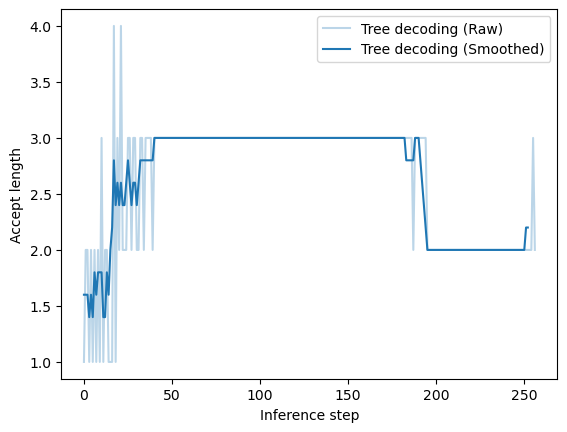

In [7]:
def moving_average(data, window_size=5):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

# Unsmoothed plots with transparency
plt.plot(accept_lengths_tree, label='Tree decoding (Raw)', alpha=0.3)
# plt.plot(accept_lengths, label='List decoding (Raw)', alpha=0.3)

# Smoothed plots
window_size = 5  # You can adjust this as needed
plt.plot(moving_average(accept_lengths_tree, window_size), label='Tree decoding (Smoothed)', color='tab:blue')
# plt.plot(moving_average(accept_lengths, window_size), label='List decoding (Smoothed)', color='tab:orange')

plt.xlabel('Inference step')
plt.ylabel('Accept length')
plt.legend()

print('Avg. accept tree length:', np.mean(accept_lengths_tree))
# print('Avg. accept list length:', np.mean(accept_lengths))

plt.show()
